In [1]:
%matplotlib inline

from numpy import sqrt, log, pi
from clawpack import riemann
from clawpack import pyclaw


def qinit(x ):
    """
    The true solution, for comparison.  
    """
    import numpy as np
      
    if isinstance(x,(np.ndarray,list)):
        m = np.size(x)
        q = np.empty((m))
        for i in range(m):
            q[i] = np.sin(np.pi*x[i])
    if isinstance(x,(float,int)):
        q = np.sin(np.pi*x)
    return q

def burgers(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d burgers riemann solver 
    """
    import numpy as np
    num_eqn = 1
    num_waves = 1

    # Convenience
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))

    delta = q_r - q_l
    
    
    # Compute the wave
    # 1-Wave
    wave[0,0,:] = delta 
    s[0,:] = 0.5 * (q_r[0,:] + q_l[0,:])
    
    # Compute the left going and right going fluctuations
    s_index = np.zeros((2,num_rp))
    s_index[0,:] = s[0,:]
    amdq[0,:] = np.min(s_index,axis=0) * wave[0,0,:]
    apdq[0,:] = np.max(s_index,axis=0) * wave[0,0,:]
        
    # Compute entropy fix
    if problem_data['efix']:
        transonic = (q_l[0,:] < 0.0) * (q_r[0,:] > 0.0)
        amdq[0,transonic] = -0.5 * q_l[0,transonic]**2
        apdq[0,transonic] = 0.5 * q_r[0,transonic]**2

    return wave, s, amdq, apdq


def setup(outdir='./_output',  output_style=1):
    
    solver = pyclaw.ClawSolver1D()
    
    #solver.rp = riemann.burgers_1D_py.burgers_1D
    #solver = pyclaw.SharpClawSolver1D()
    solver.rp = burgers
    #solver.weno_order = 5
    #solver.lim_type = 2
    #solver.time_integrator = 'SSP33'
    #solver.cfl_max = 0.5

    solver.num_waves = 1
    solver.num_eqn = 1
    solver.kernel_language = 'Python'
    solver.limiters = pyclaw.limiters.tvd.superbee
    solver.bc_lower[0] = pyclaw.BC.extrap
    solver.bc_upper[0] = pyclaw.BC.periodic
    solver.order = 2 #1: Godunov, 2: Lax-Wendroff-LeVeque
    
    x = pyclaw.Dimension(0., pi , 1000, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    
    state = pyclaw.State(domain, num_eqn)
    
     
    state.problem_data['efix'] = True
    
    xc = domain.grid.x.centers
    
    state.q[0, :] = qinit(xc)
     
    claw = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.output_style = output_style
    claw.tfinal = 1.0
    claw.num_output_times = 40
    claw.keep_copy = True
    #claw.setplot = setplot

    return claw


def setplot(plotdata):
    """ 
    Plot solution using VisClaw.
    """ 
    plotdata.clearfigures()  # clear any old figures,axes,items data

    plotfigure = plotdata.new_plotfigure(name='q', figno=1)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.ylimits = [-.2,1.0]
    plotaxes.title = 'q'

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 0
    plotitem.plotstyle = '-o'
    plotitem.color = 'b'
    plotitem.kwargs = {'linewidth':2,'markersize':5}
    
    return plotdata


2024-02-09 18:26:17,605 INFO CLAW: Solution 0 computed for time t=0.000000
2024-02-09 18:26:17,614 INFO CLAW: Solution 1 computed for time t=0.025000
2024-02-09 18:26:17,633 INFO CLAW: Solution 2 computed for time t=0.050000
2024-02-09 18:26:17,641 INFO CLAW: Solution 3 computed for time t=0.075000
2024-02-09 18:26:17,648 INFO CLAW: Solution 4 computed for time t=0.100000
2024-02-09 18:26:17,659 INFO CLAW: Solution 5 computed for time t=0.125000
2024-02-09 18:26:17,668 INFO CLAW: Solution 6 computed for time t=0.150000
2024-02-09 18:26:17,675 INFO CLAW: Solution 7 computed for time t=0.175000
2024-02-09 18:26:17,682 INFO CLAW: Solution 8 computed for time t=0.200000
2024-02-09 18:26:17,689 INFO CLAW: Solution 9 computed for time t=0.225000
2024-02-09 18:26:17,698 INFO CLAW: Solution 10 computed for time t=0.250000
2024-02-09 18:26:17,710 INFO CLAW: Solution 11 computed for time t=0.275000
2024-02-09 18:26:17,722 INFO CLAW: Solution 12 computed for time t=0.300000
2024-02-09 18:26:17,73

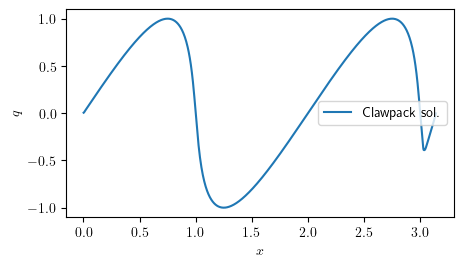

In [2]:
claw = setup()
claw.run()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
index = 10
frame = claw.frames[index]
dt = claw.tfinal/claw.num_output_times
t = dt*index
x = frame.state.grid.c_centers
x = x[0]

fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]

ax.plot(x, w, label='Clawpack sol.')

ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("InitialValueBurgerClaw.pdf")

In [6]:
# Plotting the frames at different times
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    L = 3
    hmin = -1
    hmax = 1
    fig, axes = plt.subplots(figsize=(5, 3))
    
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize=14)
    axes.set_ylabel(r'$u(x, t)$',fontsize=14)
    axes.set_xlim((0,L))
    axes.set_ylim(( hmin, hmax))
    text = axes.text(L/2, hmin+0.8*(hmax-hmin)  , '')
    
    frame = claw.frames[i]
    w  = frame.q[0,:]
    x  = frame.state.grid.c_centers
    x  = x[0]
    dt = claw.tfinal/claw.num_output_times
    t  = dt*i
    val= f'{t:.2f}'
    text.set_text(r'$  t = {} s$  '.format(val)) 
    plt.plot(x, w)
   
    figs.append(fig)
    plt.close(fig)
    
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs)   

interactive(children=(IntSlider(value=0, description='frameno', max=40), Output()), _dom_classes=('widget-inte…

In [4]:
 
def burgers_animation():
    import matplotlib.animation
    import numpy
    # compute the solution with the method define above:

    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0., pi , 1000)
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    plt.rcParams['text.usetex'] = True
    axes.set_xlabel(r'$x$',fontsize = 14)
    axes.set_ylabel(r'$u(x, t)$',fontsize = 14)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-1.1, 1.2))
    axes.set_title(" ")
    text = axes.text(1.5, 0.9, '')
    
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((-1.1,1.1))

        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'r')
        exact_line, = axes.plot(x_true[0], qinit(x_true[0]), 'k--')
        return  (computed_line, exact_line)
    
    computed_line, exact_line = init()
    #computed_line  = init()
    
    def fplot(n):
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [qinit(x_true)])
        tt = claw.frames[n].t
        
        val = f'{tt:.2f}'
        text.set_text(r'$ t = {} $ s'.format(val))
        
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=None, repeat=False)
from IPython.display import HTML 
anim = burgers_animation()
HTML(anim.to_jshtml())

In [7]:
# Exporting the frames for latex
import os
from os.path import expanduser
# Finding the home and current directories
home = expanduser("~")
cwd = os.getcwd()
user_directory = cwd

newdir = 'Burgers_IC_Snapshots'
if not os.path.isdir(newdir): os.mkdir(user_directory+"/"+newdir)
for i in range(len(figs)):
    figs[i].savefig(user_directory+'/'+newdir+'/Frame'+str(i)+'.png', bbox_inches='tight',dpi=300)
